In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass

# ThorFi as Generalized Dynamical System (GDS)

State space: whole region of states

state: current configuration of the system

State Trajectory:

Input Space: 

Admissible input space: 

State update map:
<br>
```a map which takes the current state x ∈ X and an Admissible Input u ∈ Ux to return a new State in X.```


# Parameters

In [208]:
# Pool Amplification Factor to tweak mint/redeem fees (down to force higher fees)
POOL_AMP_FACTOR = 0.999
# Saver Block Reward Frequency to tweak USD Saver yield (down to force higher yield)
SAVE_BLOCK_REWARD = 0.0
# Saver Deposit Time Minimum to tweak attracting mercenary capital (down to get more capital)
SAVE_DEPOSIT_MIN_BLOCKS = 0 # blocks
# Loan Deposit Time Minimum to tweak attracting mercenary lenders (down to get more lenders)
LOAN_DEPOSIT_MIN_BLOCKS = 0 # blocks
# Loan MaxCR to tweak attracting all lenders (down to get more lenders)
MAX_CR = 3.0 # in percent, 3 = 300%


## Data Classes

In [217]:
@dataclass
class pool: 
    pool_asset_depth: float
    pool_rune_depth: float
    pool_asset_collateral: float
    pool_rune_collateral: float
    pool_yield: float # percent
    asset_price_usd: float
        
@dataclass
class Thorchad:
    pool: str
    lp_asset_amount: float # portion of Lp in asset term
    lp_rune_amount: float # portion of lp in rune term
    debt_owed: float # in thor.usd terms
    debt_received: float # in thor.usd terms
    CR: float # collateralization ratio
    savings_asset: str # derrived asset
    savings_deposit: str # in asset units, i.e. - thor.btc

@dataclass
class RuneSupply:
    rune_supply: float # total rune supply
    rune_lend_inflation: float
    rune_save_deflation: float

@dataclass        
class LendModule:
    asset: str
    debt_minted: float
    debt_owed: float

@dataclass
class ThorUsdVault:
    fee_revenue: float
    deposits: float
    withdrawals: float
        
        

In [5]:
btc_pool = pool(pool_asset_depth=875.0,
                pool_rune_depth=5000000,
                pool_asset_collateral = 0.0, 
                pool_rune_collateral=0.0,
                pool_yield= 20.0, # percent
                asset_price_usd=40000.0,
               
               )

In [6]:
def rune_usd_mint_burn(
    x_input_amount: float, 
    X_virtual_input_side: float,
    Y_virtual_output_side:float, 
    ):
    '''
    mint / redeem
    Y = (x * X * Y) / (x + X) ** 2
    '''
        
    y_output_amount = (x_input_amount * X_virtual_input_side * Y_virtual_output_side) / (x_input_amount + X_virtual_input_side) ** 2
    

# Lending 



In [28]:
def calc_collat_ratio(P, C, uC, maxCR):
    '''
    P = total rune in pool (pooled rune)
    C = total rune in pool as loan collateral (collateral rune)
    uC = user rune collateral
    maxCR = maximum collateralization ratio
    '''
    CR = ((C + uC)/P * (maxCR-1.0)) + 1.0
    
    return CR

In [29]:
# gut check - from spreadsheet
calc_collat_ratio(P=5000000, C=0, uC=1000, maxCR=3.0) == 1.0004

True

In [209]:
def lend(r, a, R, A, Rv, Uv):
    
    """
    r: rune deposit value
    a: asset deposit value
    R: rune depth in pool
    A: asset depth in pool
    Rv: virtual rune depth
    Uv: virtual  USD depth
    
    note - pool amp factor will scale the debt minted. 
            max value of 1, lower value will increase fee to thor.usd vault
    
    returns: 
        d: total deposit value in rune
        u: debt minted for user, THOR.USD - this is the amount OWED to the protocol to get collat back.
    """
    
    d = r + (R/A * a) 
    u = (d * Rv * Uv)/(d + Rv) ** 2 * POOL_AMP_FACTOR
    
    
    return u # this is the value owed to the network


In [74]:
btc_pool.pool_rune_depth

5000000

# Lending Steps

Inputs: 
* user data class
* 

In [80]:
# gut check - from spreadsheet


RUNE_PRICE_USD = 7.0
MAX_CR = 3.0 # 300%

# Instantiate pool
btc_pool = pool(pool_asset_depth=875.0,
                pool_rune_depth=5000000,
                pool_asset_collateral = 0.0, 
                pool_rune_collateral=0.0,
                pool_yield=20.0, # percent
                asset_price_usd=40000.0,
               )

# Specify the LP position components
rune_collat = 1000 # half of LP position value
btc_collat = 0.175 # other half of LP position value

# get CR
lend_cr = calc_collat_ratio(
                P=btc_pool.pool_rune_depth,
                C=btc_pool.pool_rune_collateral,
                uC=rune_collat,
                maxCR=MAX_CR)

# Get portion of the collateral protocol is willing to lend
rune_lend = rune_collat / lend_cr 
btc_lend = btc_collat / lend_cr 

debt_owed = (rune_lend * RUNE_PRICE_USD) + (btc_lend * btc_pool.asset_price_usd)

debt_minted = lend(
                r = rune_lend, # in rune terms
                a = btc_lend, # in asset terms
                R = btc_pool.pool_rune_depth, 
                A = btc_pool.pool_asset_depth, 
                Rv = 10000000, # RUNE in THOR.USD/RUNE pool
                Uv = 70000000, # THOR.USD in THOR.USD/RUNE pool
            )

print(f"debt Minted: {np.round(debt_minted, 2)} thor.usd ")
print(f"debt_owed by borrower: {np.round(debt_owed,2)} thor.usd")
print(f"THOR.USD Vault Income: {np.round(debt_owed - debt_minted, 2)} thor.usd")

round(debt_minted, 0) == 13989

debt Minted: 13988.81 thor.usd 
debt_owed by borrower: 13994.4 thor.usd
THOR.USD Vault Income: 5.59 thor.usd


True

# Create a user 

In [93]:

# btc_lper = Thorchad(
#             pool="BTC.BTC",
#             lp_asset_amount=0.175, # portion of Lp in asset term
#             lp_rune_amount=1000, # portion of lp in rune term
#             debt_owed=0, # in thor.usd terms
#             debt_received=0) # in thor.usd terms)

In [95]:
# Sim steps
1. generate 100 lpers, sampling from distribution
2. with the 10 Lpers, generate 10 loans



# Generate LPers

In [105]:
np.random.seed(seed=42)

In [210]:
lper_list = []
for user in range(0, 1000):
    
    rune_lp = np.random.exponential(scale=0.99) * 1000,
    assets_lp = rune_lp[0] / 5714.28 # rune per btc 
    
    tc = Thorchad(
        pool = "BTC.BTC",
        lp_rune_amount = rune_lp[0], #
        lp_asset_amount = assets_lp,
        debt_owed=0.0,
        debt_received=0.0,
        CR=0.0
        )
    
    lper_list.append(tc)

In [193]:
len(lper_list)

1000

In [211]:
lper_list[0]

Thorchad(pool='BTC.BTC', lp_asset_amount=0.23905969384888445, lp_rune_amount=1366.0540273668034, debt_owed=0.0, debt_received=0.0, CR=0.0)

In [195]:
# get total rune and btc of the users

In [212]:
rune_list = []
asset_list = []

for lp in lper_list:
    
    rune_list.append(lp.lp_rune_amount)
    asset_list.append(lp.lp_asset_amount)

In [213]:
sum(rune_list), sum(asset_list)

(958971.635524215, 167.82020403694148)

instantiate the btc pool

**States:** 
1. Pool state, current  - incl. apy etc.
2. lend module, current
3. rune supply, current 
4. thor.usd vault, current 
5. user, current ( do we need to consider past states? I think so as this is not a markov process and trajectory matters.)
6. Asset Vaults (thor.usd, btc etc.)

**Inputs:** 
1. block height
1. new loan
1. loan repayment
1. new savings deposit
1. savings withdrawal
1. asset/rune prices, usd
1. pool depths - thor.usd, asset
1. withdrawal threshold - 100 days
1. if price down/up - what behaviors are reasonable or not? 
1. price change, rune, usd terms
1. fud threshold - 
1. "attractive" savings yield
1. "attractive" CR - do we make a demand curve... 
1. propensity to participate
can we get this from aave?
1. borrow - repayment time frame, 100 days vs 20 days.
1. savings - redemtion period? 7 days? 14? 

Q: Any biz logic to filter down the admissible input space and subsequent map? 

**riffing on Admissible input space ideas**
1. based on block height - cant decrease lol.
1. IL in pools!
1. price feed - steady, shock up/down, trend up/down
1. behavior of borrower and saver 
1. flee from crypto
1. large pool sift.
1. distribution of borrowers, savers?
1. static pool depth, large  thorfi demand 
1. pool depth grows with  thofi demand
1. pool depth decrease with thorfi demand
1. pool dpeth decrease with thorfi decrease (chill during a blizard)

**state update map mechanisms:**

1. Iterate block height

Borrow
1. borow - Collateralization Ratio
1. borrow - update user borrow balance, recived, owed  
1. borrow - calculate summary stats of all borrow positions at that state. 

both
1. Iterate block height
1. borrow,save - Thor.usd vault fees generated.
1. borrow, save - daily yield from reported apy

thor.usd
1. Mint/ burn thor.usd + fees

save 
1. save - asset Savings Vault update 

1. Calculate pro rata share for users of Savings Vault
1. save - calculate ILP of the pooled collateral. 
1. 

In [219]:
btc_pool = pool(pool_asset_depth=875.0,
                pool_rune_depth=5000000,
                pool_asset_collateral = 175.0, 
                pool_rune_collateral=1000000,
                pool_yield=20.0, # percent
                asset_price_usd=40000.0,
               )


btc_lend_module =  LendModule(
        asset="BTC.BTC",
        debt_minted=0,
        debt_owed=0
    )


rune_supply_tracker = RuneSupply(
                        rune_supply=0,
                        rune_lend_inflation=0,
                        rune_save_deflation=0 
                    )


usd_vault = ThorUsdVault(
             fee_revenue=0.,
                deposits=0.,
                withdrawals=0.
             )

# Generate loans

In [200]:
import random

In [220]:
for user in random.sample(lper_list, 200):
    

    # Specify the LP position components
    rune_collat = user.lp_rune_amount # half of LP position value
    btc_collat = user.lp_asset_amount # other half of LP position value
    
    collat_usd_value = (rune_collat  * RUNE_PRICE_USD) + (btc_collat * btc_pool.asset_price_usd)
    
    # get CR
    lend_cr = calc_collat_ratio(
                    P=btc_pool.pool_rune_depth,
                    C=btc_pool.pool_rune_collateral,
                    uC=rune_collat,
                    maxCR=MAX_CR)
    
    # Get portion of the collateral protocol is willing to lend
    rune_lend = rune_collat / lend_cr 
    btc_lend = btc_collat / lend_cr 

    debt_owed = (rune_lend * RUNE_PRICE_USD) + (btc_lend * btc_pool.asset_price_usd)

    debt_minted = lend(
                    r = rune_lend, # in rune terms
                    a = btc_lend, # in asset terms
                    R = btc_pool.pool_rune_depth, 
                    A = btc_pool.pool_asset_depth, 
                    Rv = 10000000, # RUNE in THOR.USD/RUNE pool
                    Uv = 70000000, # THOR.USD in THOR.USD/RUNE pool
                )
    
    # now increase the lend module balances
    btc_lend_module.debt_minted = btc_lend_module.debt_minted + debt_minted
    btc_lend_module.debt_owed = btc_lend_module.debt_owed = debt_owed
    
    # increase portion of the pool that is Collateral
    btc_pool.pool_rune_collateral = btc_pool.pool_rune_collateral + rune_collat
    btc_pool.pool_asset_collateral = btc_pool.pool_asset_collateral + btc_collat
    
    
    # increase rune supply
    rune_previous_stately_tracker.rune_lend_inflation = rune_supply_tracker.rune_lend_inflation + (debt_owed / RUNE_PRICE_USD)
    
    print('-' * 10)
    print(f"deposit value of user: rune colat {np.round(rune_collat, 2)}, total {np.round(collat_usd_value,2)} thor.usd")
    print(f"thor.usd recived by user: {np.round(debt_minted, 2)} thor.usd ")
    print(f"thor.usd owed by user: {np.round(debt_owed,2)} thor.usd")
    print(f"THOR.USD Vault Income: {np.round(debt_owed - debt_minted,  5)} thor.usd")
    usd_vault.fee_revenue = usd_vault.fee_revenue + np.round(debt_owed - debt_minted,  5)
    print(f"Rune supply inflated by: {np.round(debt_owed / RUNE_PRICE_USD, 2)} RUNE")
    print(f"User's CR: {np.round(lend_cr, 4)}")

----------
deposit value of user: rune colat 1618.87, total 22664.15 thor.usd
thor.usd recived by user: 16157.54 thor.usd 
thor.usd owed by user: 16181.19 thor.usd
THOR.USD Vault Income: 23.65201 thor.usd
Rune supply inflated by: 2311.6 RUNE
User's CR: 1.4006
----------
deposit value of user: rune colat 396.89, total 5556.51 thor.usd
thor.usd recived by user: 3962.24 thor.usd 
thor.usd owed by user: 3966.65 thor.usd
THOR.USD Vault Income: 4.41572 thor.usd
Rune supply inflated by: 566.66 RUNE
User's CR: 1.4008
----------
deposit value of user: rune colat 1796.59, total 25152.3 thor.usd
thor.usd recived by user: 17919.24 thor.usd 
thor.usd owed by user: 17946.38 thor.usd
THOR.USD Vault Income: 27.13572 thor.usd
Rune supply inflated by: 2563.77 RUNE
User's CR: 1.4015
----------
deposit value of user: rune colat 1401.7, total 19623.82 thor.usd
thor.usd recived by user: 13976.58 thor.usd 
thor.usd owed by user: 13996.16 thor.usd
THOR.USD Vault Income: 19.58582 thor.usd
Rune supply inflated 

In [206]:
rune_supply_tracker

RuneSupply(rune_supply=0, rune_lend_inflation=217911.14682960612, rune_save_deflation=0)

In [229]:
btc_pool.pool_rune_collateral, btc_pool.pool_asset_collateral

(1216093.5887052168, 212.8164158398288)

In [230]:
btc_pool.pool_yield

20.0

# Savings 

savings has the following components:
1. yield from loan collateral 
2. deposits of derrived asset
2b. increase the rune_save_deflation value
2. block and user for each deposit
3. 

In [222]:
testy = (1000, 1, "abc")

In [224]:
testy[0] = 'A'

TypeError: 'tuple' object does not support item assignment

In [231]:
block = [1, 2, 3, 4, 5]
reward = [100,100,100,100, 100]
user1 = [1,1,1,1,1]
user2 = [0,0,0, 1]

In [232]:
sum(reward)

500

In [225]:
from typing import List, Tuple

In [273]:
@dataclass

class SavingsVault:
    derrived_asset: float
    fee_revenue: float
    total_deposits: float
    total_withdrawals: float
    user_deposits: List[Tuple[int, float, str]] # block, amount, user
    block_balance: List[Tuple[int, float, float]] # block, amount, block yield

In [274]:
btcVault = SavingsVault(
            derrived_asset='thor.btc',
            total_deposits=0,
            fee_revenue=0,
            total_withdrawals=0,
            user_deposits = [],
            block_balance = []
)

In [288]:
btc_pool

pool(pool_asset_depth=875.0, pool_rune_depth=5000000, pool_asset_collateral=212.8164158398288, pool_rune_collateral=1216093.5887052168, pool_yield=20.0, asset_price_usd=40000.0)

In [289]:
type(btc_pool)

__main__.pool

In [294]:
def get_savings_daily_yield(pool):
    
    
    savings_apr = (pool.pool_asset_depth * pool.pool_yield) * (pool.pool_asset_collateral / pool.pool_asset_depth)
    
    return savings_apr / 365
    

In [293]:
get_savings_daily_yield(btc_pool)

4256.3283167965765

In [275]:
# A user deposits 1 btc

current_block = 100
block_yield = get_daily_yield(apy=20.0) # we will pretend that a block is a day


# Saver
user = "jane"
jane_deposit_amount = 1.0 # 1 btc
jane_withdrawal = 0.0
jane_deposit_block = current_block


# Add the deposit to the Vault
btcVault.user_deposits.append((jane_deposit_block, jane_deposit_amount,  user))

###
# Updates
###

# Update the total_deposits
btcVault.total_deposits = btcVault.total_deposits + jane_deposit_amount - jane_withdrawal

# update withdrawals if applicable
if jane_withdrawal > 0.0: 
    btcVault.total_withdrawals = btcVault.total_withdrawals + jane_withdrawal

# update the block_balance
btcVault.block_balance.append((current_block, btcVault.total_deposits, block_yield))


# update the Rune Supply Tracker 
asset_price_in_rune = btc_pool.pool_rune_depth / btc_pool.pool_asset_depth

rune_supply_tracker.rune_save_deflation = jane_deposit_amount * asset_price_in_rune # in RUNE

In [287]:
btc_pool.pool_rune_depth / btc_pool.pool_asset_depth  * 1

5714.285714285715

In [276]:
for block in range(100, 465):
    # update the block_balance
    btcVault.block_balance.append((block, btcVault.total_deposits, block_yield))

In [279]:
# Pro rata share for each depositor at each block

def calculate_pro_rata_shares(SavingsVault):

    '''
    for each user calculate the total amount of asset they've earned
    after the initial deposit block.
    
    '''
    
    for user in SavingsVault.user_deposits:

        deposit_block = user[0]
        deposit_amount = user[1]
        user_name = user[2]

        user_earnings = 0

        for block in SavingsVault.block_balance:

            vault_ownership = deposit_amount / block.total_deposits
            
            if block[0] > deposit_block:

                user_earnings += deposit_amount * vault_ownership * block[2] # block yield

        print(f"{user_name} earned: {user_earnings}") 

In [280]:
calculate_pro_rata_shares(SavingsVault=btcVault)

jane earned: 0.19945205479452124


In [270]:
for dep in btc_Vault.user_deposits:
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-270-41163589acc2>, line 1)

In [250]:
def get_daily_yield(apy: float):
    
    ''' 
    apy in percentage terms, 20.0 = 20%
    '''
    
    return apy / 100 / 365

In [251]:
get_daily_yield(20)

0.0005479452054794521

In [248]:
# how to calculate earnings for jane? 

# pool apy per block...

 = 20 = (0.0005479452055 * 365)



0.2000000000075

In [241]:
20%

0.0547945205479452

In [234]:
btcVault.deposits

[(100, 1.0, 'jane')]

In [ ]:


 rune_amount = np.random.exponential(scale=0.99, size=1) * 1000

In [100]:
rune_amount[1]

400.2130260734284

In [101]:
import matplotlib.pyplot as plt

(array([44., 19., 23.,  5.,  2.,  4.,  0.,  2.,  0.,  1.]),
 array([4.17190203e-01, 5.38473031e+02, 1.07652887e+03, 1.61458471e+03,
        2.15264055e+03, 2.69069639e+03, 3.22875224e+03, 3.76680808e+03,
        4.30486392e+03, 4.84291976e+03, 5.38097560e+03]),
 <BarContainer object of 10 artists>)

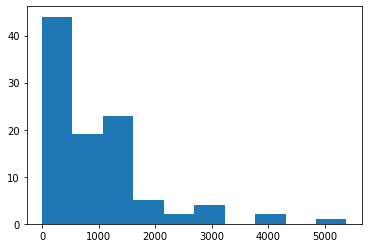

In [104]:
plt.hist(rune_amount)